### ML Modelling
This notebook walks through the process of developing ML models both in sk-learn and in sasviya.ml

In [1]:
import pandas as pd 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import random 
import numpy as np
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sasviya.ml.tree import ForestClassifier
import matplotlib.pyplot as plt
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
data_path = '../../Data/cleaned_data/train_valid_test.csv'
numerical_features = ['CreditLineAge','DebtIncRatio','FICOScore','Inquiries6Mnths',
                      'LogAnnualInc','RevBalance','RevUtilization','Installment','InterestRate']
categorical_features = ['CreditPolicy','Delinquencies2Yrs','PublicRecord','Purpose']
features = numerical_features+categorical_features
target = 'Default'

In [3]:
all_data = pd.read_csv(data_path)

train = all_data[all_data['_PartInd_']==1].reset_index(drop=True)
valid = all_data[all_data['_PartInd_']==2].reset_index(drop=True)
test = all_data[all_data['_PartInd_']==3].reset_index(drop=True)

train_defaults = train[target].sum()
valid_defaults = valid[target].sum()
test_defaults = test[target].sum()
print('Train Size:', train.shape[0], f'--- {target} Frequency:', f'{round(100*train_defaults/train.shape[0],2)}%')
print('Valid Size:', valid.shape[0], f'--- {target} Frequency:', f'{round(100*valid_defaults/valid.shape[0],2)}%')
print('Test Size:', test.shape[0], f'--- {target} Frequency:', f'{round(100*test_defaults/test.shape[0],2)}%')

Train Size: 70000 --- Default Frequency: 21.6%
Valid Size: 20000 --- Default Frequency: 21.6%
Test Size: 10000 --- Default Frequency: 21.6%


In [4]:
### SK-Learn Pipeline
num_pipeline = Pipeline([
    ("standard_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot_encoder", OneHotEncoder()),
])

sk_pipeline = Pipeline([
    ("data_prep", ColumnTransformer([("num_pipeline", num_pipeline, numerical_features),("cat_pipeline", cat_pipeline, categorical_features)])),
    ('Forest_Model', RandomForestClassifier())])

sk_pipeline

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['CreditLineAge',
                                                   'DebtIncRatio', 'FICOScore',
                                                   'Inquiries6Mnths',
                                                   'LogAnnualInc', 'RevBalance',
                                                   'RevUtilization',
                                                   'Installment',
                                                   'InterestRate']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['CreditPolicy',
                                                   'Delinquencies2Yrs',
                                                   'PublicRecord',
                                                   'Purpose'])])),
                ('Forest_Model', RandomForestClassifier())])

In [5]:
#fit the pipeline
sk_pipeline.fit(train[features], train[target])
#Save predictions 
train_pred_sk = sk_pipeline.predict(train[features])
valid_pred_sk = sk_pipeline.predict(valid[features])
test_pred_sk = sk_pipeline.predict(test[features])
#Compute Fit Metrics
train_f1_sk = f1_score(train[target], train_pred_sk)
valid_f1_sk = f1_score(valid[target], valid_pred_sk)
test_f1_sk = f1_score(test[target], test_pred_sk)

In [6]:
viya_pipeline = Pipeline([
    ("data_prep", ColumnTransformer([("num_pipeline", num_pipeline, numerical_features),("cat_pipeline", cat_pipeline, categorical_features)])),
    ('Forest_Model', ForestClassifier())])

viya_pipeline

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['CreditLineAge',
                                                   'DebtIncRatio', 'FICOScore',
                                                   'Inquiries6Mnths',
                                                   'LogAnnualInc', 'RevBalance',
                                                   'RevUtilization',
                                                   'Installment',
                                                   'InterestRate']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['CreditPolicy',
                                                   'Delinquencies2Yrs',
                                                   'PublicRecord',
                                                   'Purpose'])])),
                ('Forest_Model', ForestClassifier())])

In [7]:
#fit the pipeline
viya_pipeline.fit(train[features], train[target])
#Save predictions 
train_pred_viya = viya_pipeline.predict(train[features])
valid_pred_viya = viya_pipeline.predict(valid[features])
test_pred_viya = viya_pipeline.predict(test[features])
#Compute Fit Metrics
train_f1_viya = f1_score(train[target], train_pred_viya)
valid_f1_viya = f1_score(valid[target], valid_pred_viya)
test_f1_viya = f1_score(test[target], test_pred_viya)

In [8]:
model_comparison = pd.DataFrame(
    {'Forest-SK': [train_f1_sk, valid_f1_sk, test_f1_sk], 
     'Forest-Viya': [train_f1_viya, valid_f1_viya, test_f1_viya]},
    ['Train F1', 'Valid F1', 'Test F1'])
100*model_comparison.round(4)

,Forest-SK,Forest-Viya
Train F1,99.99,55.26
Valid F1,44.72,40.87
Test F1,42.96,41.24


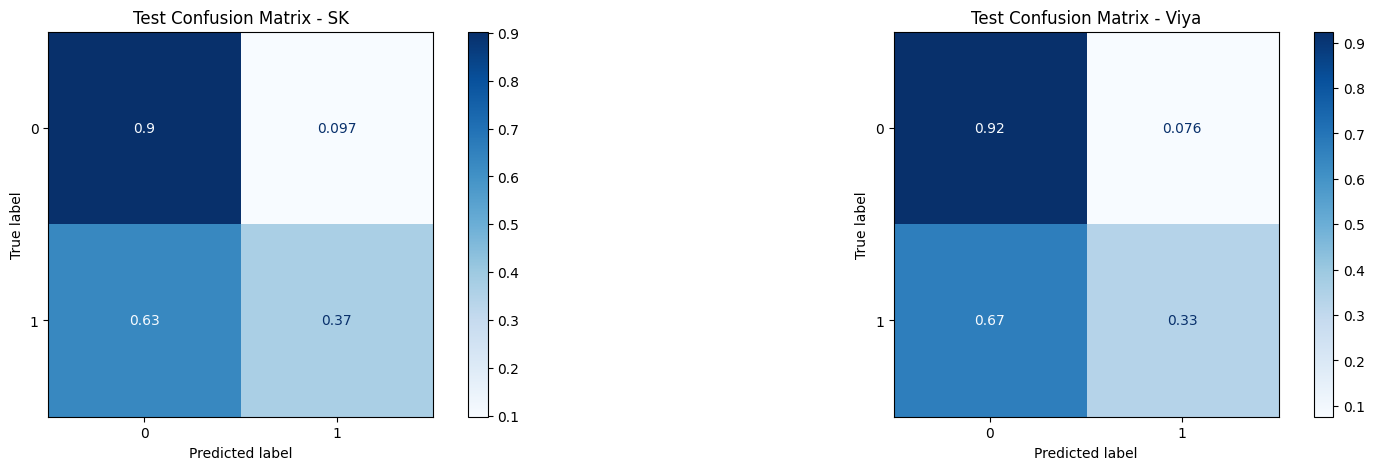

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
disp = ConfusionMatrixDisplay(confusion_matrix(test[target], test_pred_sk, normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Test Confusion Matrix - SK')

disp = ConfusionMatrixDisplay(confusion_matrix(test[target], test_pred_viya, normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title('Test Confusion Matrix - Viya')

plt.show()

### Your Task

Develop a Gradient Boosting Model, test different hyperparameters and compare its performance against the above trained Logistic and Forest Models.

![GB Classifier Overview](../../img/GB_Details_Python.png)

For further guidance: https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/explore/n1kiea90s0276wn1xr0ig0hvkix6.htm

In [ ]:
from sasviya.ml.tree import GradientBoostingClassifier

In [ ]:
# Instantiate the model, fit it and evaluate it

In [ ]:
# Make sure to compute the Train F1, Valid F1 and Test F1
model_comparison = pd.DataFrame(
    {'Forest-SK': [train_f1_sk, valid_f1_sk, test_f1_sk], 
     'Forest-Viya': [train_f1_viya, valid_f1_viya, test_f1_viya],
     'GB': [_________]},
    ['Train F1', 'Valid F1', 'Test F1'])
100*model_comparison.round(4)

In [ ]:
# Produce confusion matrices to compare performance against the Logistic Regression and the Gradient Boosting
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
disp = ConfusionMatrixDisplay(confusion_matrix(test[target], test_pred_sk, normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Test Confusion Matrix - Logistic')

disp = ConfusionMatrixDisplay(confusion_matrix(test[target], test_pred_viya, normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title('Test Confusion Matrix - Forest')

disp = ConfusionMatrixDisplay(confusion_matrix(test[target], _______, normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[2])
axs[2].set_title('Test Confusion Matrix - GB')

plt.show()

### Saving Models
We create an artifacts folder and save the models

In [13]:
mypath = 'artifacts'
if not os.path.isdir(mypath):
   os.makedirs(mypath)

with open('artifacts/sklearn_forest_pipeline.pkl', 'wb') as file:
    pickle.dump(sk_pipeline, file)

with open('artifacts/viya_forest_pipeline.pkl', 'wb') as file:
    pickle.dump(viya_pipeline, file)